In [364]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [398]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN', 'GraphSAGE', 'SGC', 'MLP']
METRIC = 'test_rocauc_ovr' #val_rocauc_ovr   val_logloss
PARAM = 'p_to_q_ratio'


In [399]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results_df.columns

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent', 'ktrain',
       'generator_name', 'n_nodes', 'n_edges', 'edge_density', 'avg_in_degree',
       'edge_reciprocity', 'avg_undirected_degree', 'degree_gini',
       'pseudo_diameter', 'coreness_eq_1', 'coreness_geq_2', 'coreness_geq_5',
       'coreness_geq_10', 'coreness_gini', 'avg_local_cc', 'global_cc',
       'cc_size', 'edge_homogeneity', 'avg_in_feature_angular_distance',
       'avg_out_feature_angular_distance', 'feature_angular_snr',
       'pareto_exponent', 'avg_degree_est', 'community_size_simpsons',
       'p_to_q_ratio_est', 'p_to_q_ratio__est_dc', 'skipped', 'sample_id',
       'GCN__val_accuracy', 'GCN__val_f1_micro', 'GCN__val_f1_macro',
       'GCN__val_rocauc_ovr', 'GCN__val_rocauc_ovo', 'GCN__val_logloss',
       'GCN__test_accuracy', 'GCN__test_f1_micro', 'GCN__tes

In [400]:

columns = results_df.columns

processd_dict = {col : [] for col in columns}

train_pq_min = 4.0

for row in results_df.itertuples():
    param = getattr(row, PARAM)
    if param[0] > train_pq_min and param[0] < train_pq_min + 1:
        len_param = len(param)
        for col in columns:
            val = getattr(row, col)
            if isinstance(val, list):
                processd_dict[col] += val[1:]
            else:
                processd_dict[col] += [val] * (len_param - 1)

processd_df = pd.DataFrame.from_dict(processd_dict)
    
print(len(results_df))
print(len(processd_df))



1000
464


In [401]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=10, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s__%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s (train_pq [%s,%s])' % (metric, param, train_pq_min, train_pq_min+1))
  plt.show()

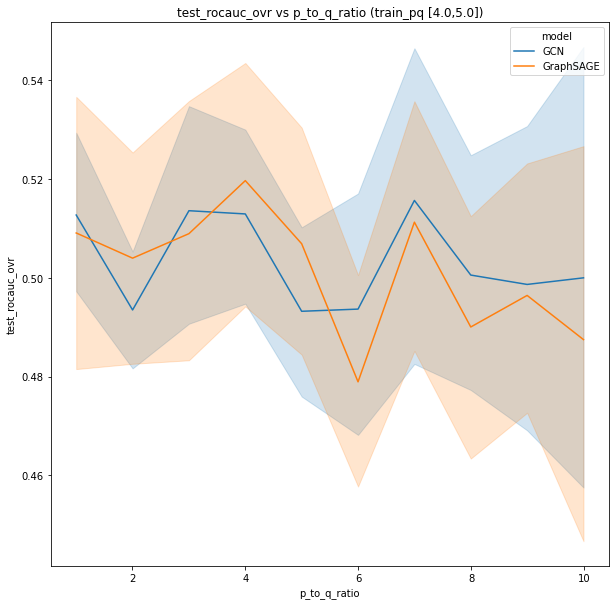

In [402]:
# plot_response_surface1d('feature_center_distance', METRIC, results_df) 
plot_response_surface1d(PARAM, METRIC, processd_df)